In [1]:
import climate_functions as cf
import numpy as np
import synthetic_data as sd
import network_builder as nb
import networkx as nx
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
#from fastdtw import fastdtw
#from dtaidistance import dtw
#from dtaidistance import dtw_visualisation as dtwvis
#from dtaidistance import clustering
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
sns.set()
import random
import pandas as pd
from netCDF4 import Dataset
from stldecompose import decompose, forecast
import folium
import math
import scipy.stats as st
#import cufflinks as cf
import plotly 
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='mohammad5617', api_key='yElRsXEjk0sRoqCmfVBn')
import plotly.io as pio
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.x13 import x13_arima_analysis

/home/mathsys2/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
f_pre = Dataset('precipitation.nc')
pr = f_pre.variables['precip']
lon = f_pre.variables['lon'][:]
lat = f_pre.variables['lat'][:]
pr = np.swapaxes(pr,0,2)

r = np.arange(0.05,1,0.05)

In [3]:
#data = pr[14:22,3:7,:]
#data = pr[10:22,3:11,:]
data = pr[16:23,10:16,:]
#data = pr[0:6,0:6,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
data = cf.refine_data(data)

In [151]:
XPATH = "./x13as"
a = x13_arima_analysis(endog = data[:,5],print_stdout=True,start = '1946-01-01',freq = 'M',x12path=XPATH)

b''


In [155]:
X = [i%12 for i in range(0, len(series))]

In [157]:
len(X)

841

In [183]:
series = data[:,5]
X = [i%12 for i in range(0, len(series))]
degree = 2
coef = np.polyfit(X, series, degree)
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

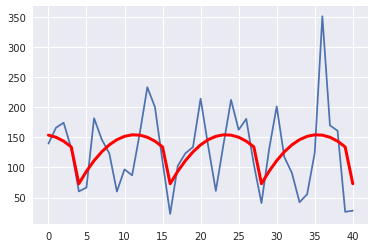

In [184]:
plt.plot(series[800:])
plt.plot(curve[800:], color='red', linewidth=3)
plt.show()

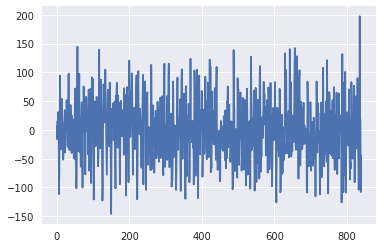

In [185]:
plt.plot(series - curve)

In [142]:
open('result.txt', 'w').write(a.results)

255738

In [126]:
i = a.results.find("Date   Forecast      Error\n   ------------------------------\n   ")

In [127]:
float(a.results[i+73:i+85].strip())

45.41

In [149]:
def deseasonal_X13(data,start = '1946-01-01',freq = 'M'):
    XPATH = "./x13as"
    n = data.shape[1]
    data_deseasonal = np.zeros(data.shape)
    data_seasonal = np.zeros(data.shape)
    for i in range(n):
        print(i)
        result = x13_arima_analysis(endog = data[700:,i],start = start,freq = freq, x12path=XPATH,forecast_years=1)
        data_deseasonal[:,i] = result.seasadj.values
       # Idx = result.results.find("Date   Forecast      Error\n   ------------------------------\n   ")
       # data_seasonal[i] = float(result.results[Idx+73:Idx+85].strip())
        data_seasonal[:,i] = data[:,i] - data_deseasonal[:,i]
    return(data_deseasonal, data_seasonal)

In [138]:
x13_arima_analysis(endog = data[:,0],start = start,freq = freq, x12path=XPATH,forecast_years=1)

NameError: name 'start' is not defined

In [187]:
a = np.array([1,2,3,4,5,6,7,8,9])

In [190]:
a[-0:]

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [3]:
lon = pr.shape[0]
lat = pr.shape[1]

In [5]:
MSEds_list = []
MSE_list = []
MSEdm_list = []
null_list =[]

start = 0
end = 841
for i in range(0,lon-7,2):
    for j in range(0,lat-20,2):
        data = pr[i:i+7,j:j+7,:]
        data = cf.unflatten(data)
        data = np.swapaxes(data,0,1)
        data = cf.refine_data(data)

        MSE, density = cf.model(data,"LR","normal",start=start,end=end, data_type="normal")
        MSE_list.append(MSE)

        MSE_ds, density_ds = cf.model(data,"LR","normal",start=start,end=end, data_type="STL")
        MSEds_list.append(MSE_ds)

        MSE_dm,density_dm = cf.model(data,"LR","normal",start=start,end=end, data_type="PA")
        MSEdm_list.append(MSE_dm)

In [6]:
f = np.matrix(MSE_list).mean(axis=0)
MSE = np.reshape(f,(19,1))

f1 = np.matrix(MSEds_list).mean(axis=0)
MSE_ds = np.reshape(f1,(19,1))

f2 = np.matrix(MSEdm_list).mean(axis=0)
MSE_dm = np.reshape(f2,(19,1))

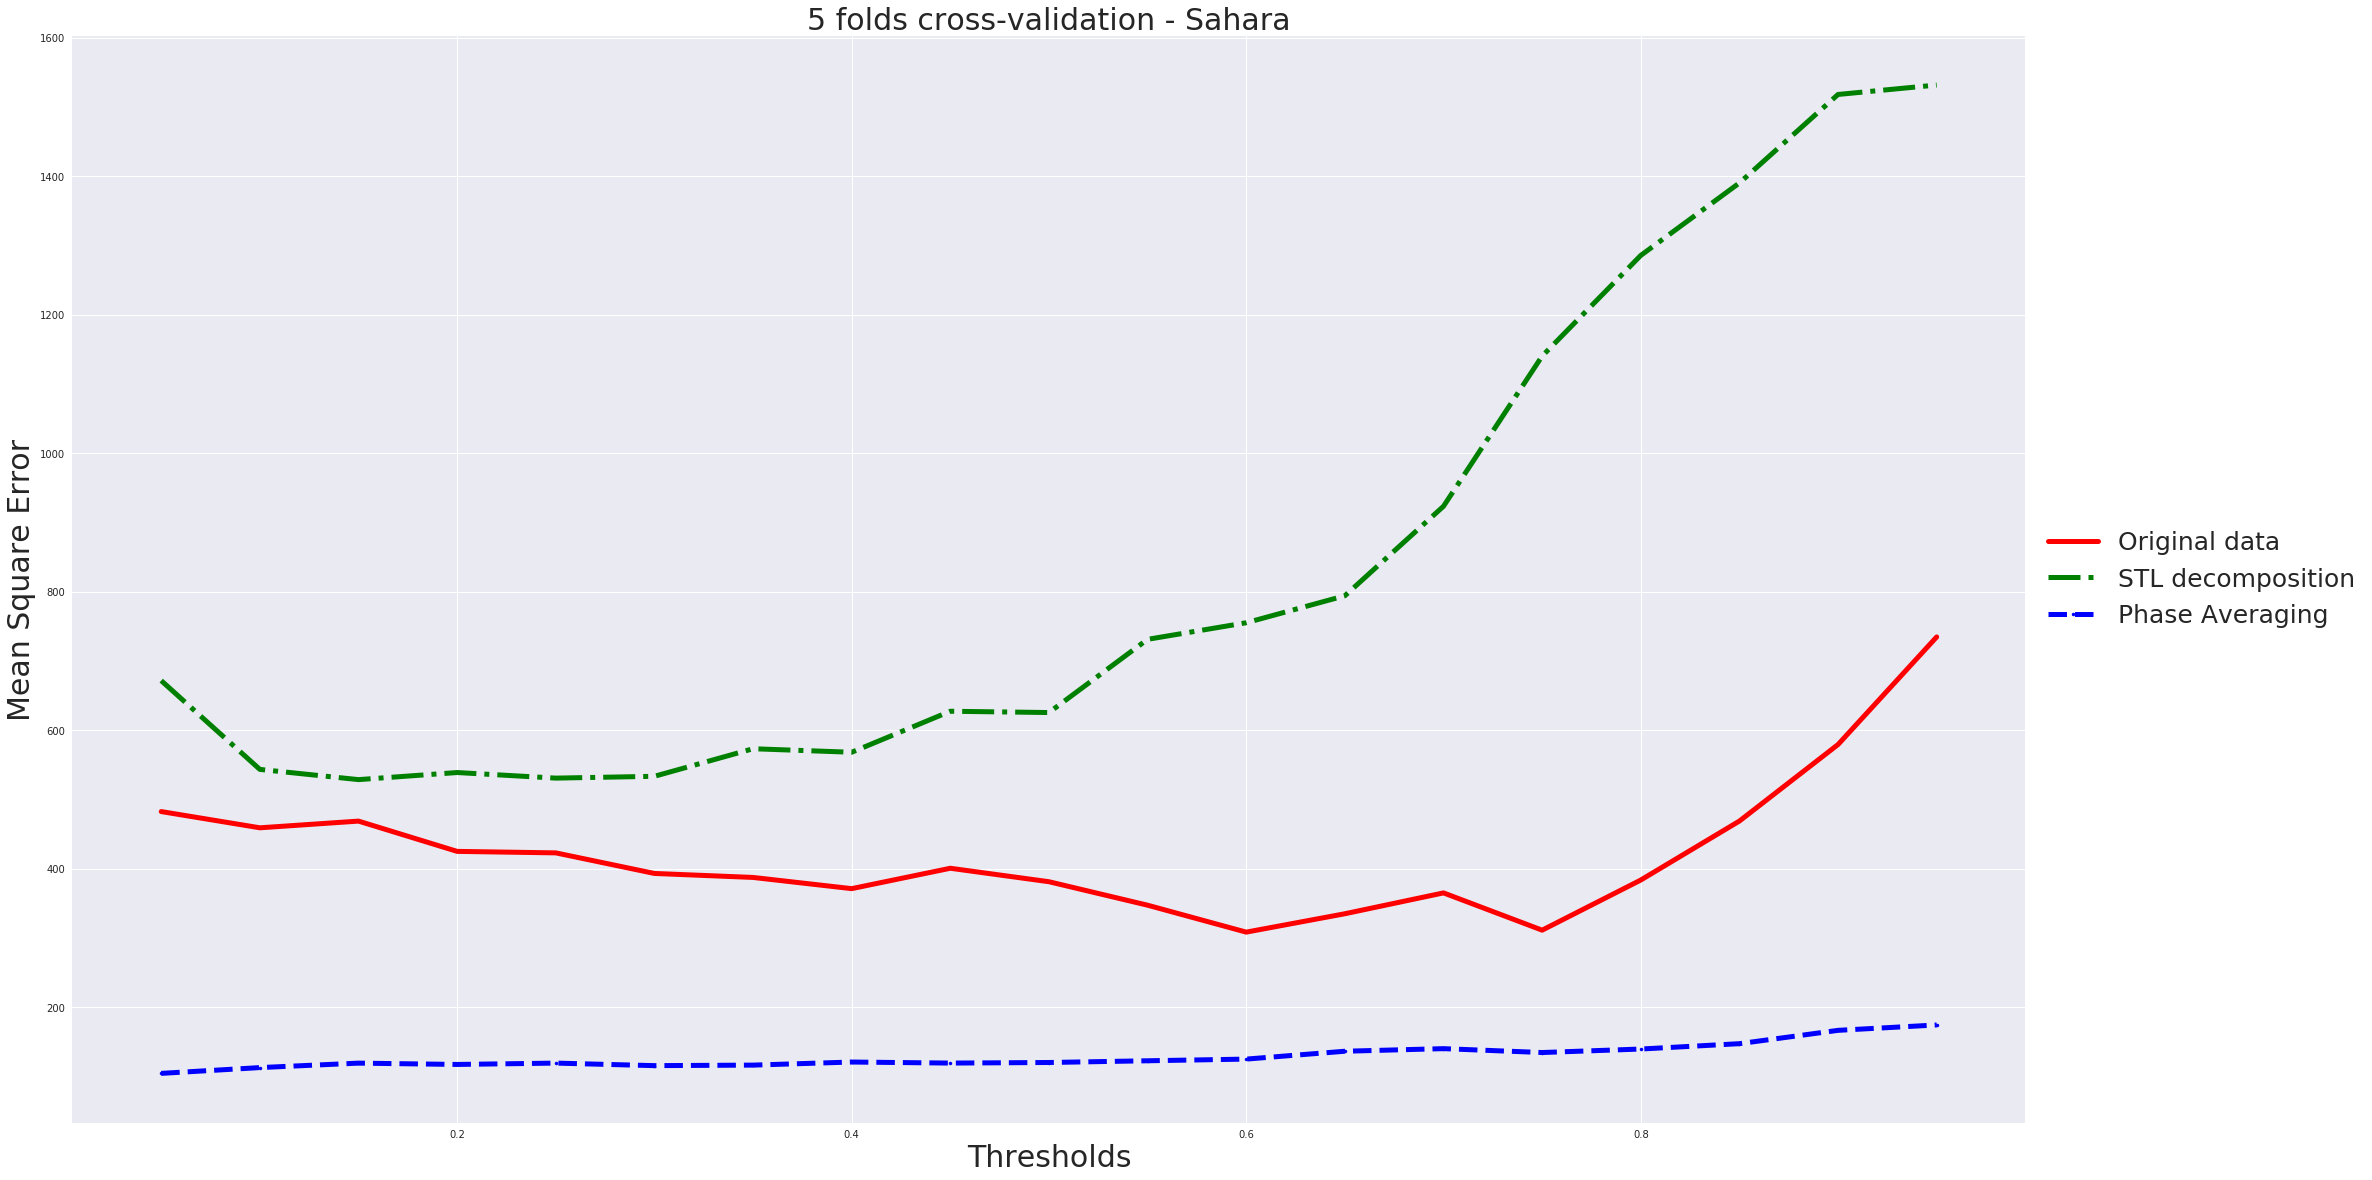

In [7]:
plt.figure(figsize=(35,20))
plt.plot(r, MSE, 'r-', r, MSE_ds, 'g-.',r,MSE_dm, 'b--.',linewidth=5)
plt.xlabel('Thresholds',fontsize=30)
plt.ylabel('Mean Square Error',fontsize=30)
plt.title('5 folds cross-validation - Sahara',fontsize=30)
plt.legend(['Original data','STL decomposition', 'Phase Averaging'], ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize =25)
#plt.savefig("performance_cross_sahara5small.png")

In [8]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)


d = [trace0,trace1, trace2]
    
layout = dict(title = 'evaluation on a rolling forecasting origin - Linear Regression',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error',
                         )
       )

fig = dict(data=d, layout=layout)
#pio.write_image(fig, 'performance_cross5.png')
py.iplot(fig, filename='styled-line')

# Cross validation

In [ ]:
data_deseasonal= cf.deseasonal_STL(data)
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
data_deseasonal_monthly= cf.deseasonal_monthly_anomaly(data)
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

upper_bound = go.Scatter(
    name='Upper Bound',
    x=r,
    y=r2_upper,
    mode='lines',
    marker=dict(color="#444"),
    line=dict(width=0),
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty'
)

lower_bound = go.Scatter(
    name='Lower Bound',
    x=r,
    y=r2_lower,
    mode='lines',
    marker=dict(color="#444"),
    line=dict(width=0)
)

In [8]:
MSEds_list = []
MSE_list = []
MSEdm_list = []
null_list =[]
for i in range(0,840,168):
    MSE, average_betweennes, average_shortest_path_length,density = cf.model(data,"LR","normal",start=i,end=i+168, data_type="normal")
    MSE_list.append(MSE)
    
    MSE_ds, average_betweennes_ds, average_shortest_path_length_ds, density_ds = cf.model(data,"LR","normal",start=i,end=i+168, data_type="STL")
    MSEds_list.append(MSE_ds)

    MSE_dm, average_betweennes_dm, average_shortest_path_length_dm,density_dm = cf.model(data,"LR","normal",start=i,end=i+168, data_type="PA")
    MSEdm_list.append(MSE_dm)
    
 #   null = cf.exponential_smoothing(data[i:i+168-1,:], 0.95)
 #   error = mean_squared_error(data[i+168-1,:], null)
 #   null_list.append(error)

In [64]:
#f = np.matrix(r2_list).std(axis=0)/math.sqrt(20) * 1.96
#r2_list_bounds = np.reshape(f,(18,1))
#r2_list_bounds = r2_list_bounds.tolist()[0]


In [5]:
#null = np.mean(null_list)
#nullr2ds = np.mean(nullds_list)

In [9]:
f = np.matrix(MSE_list).mean(axis=0)
MSE = np.reshape(f,(19,1))

f1 = np.matrix(MSEds_list).mean(axis=0)
MSE_ds = np.reshape(f1,(19,1))

f2 = np.matrix(MSEdm_list).mean(axis=0)
MSE_dm = np.reshape(f2,(19,1))

#r_rev = r[::-1]#

#r2_upper = r2 + r2_list_bounds
#r2_lower = r2 - r2_list_bounds

In [15]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)


d = [trace0,trace1, trace2]
    
layout = dict(title = 'evaluation on a rolling forecasting origin - Linear Regression',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error',
                         )
       )

fig = dict(data=d, layout=layout)
#pio.write_image(fig, 'performance_cross5.png')
py.iplot(fig, filename='styled-line')

In [3]:
MSE = np.load('MSE_RF_overall.npy')
MSE_ds = np.load('MSE_RF_ds_overall.npy')
MSE_dm = np.load('MSE_RF_dm_overall.npy')

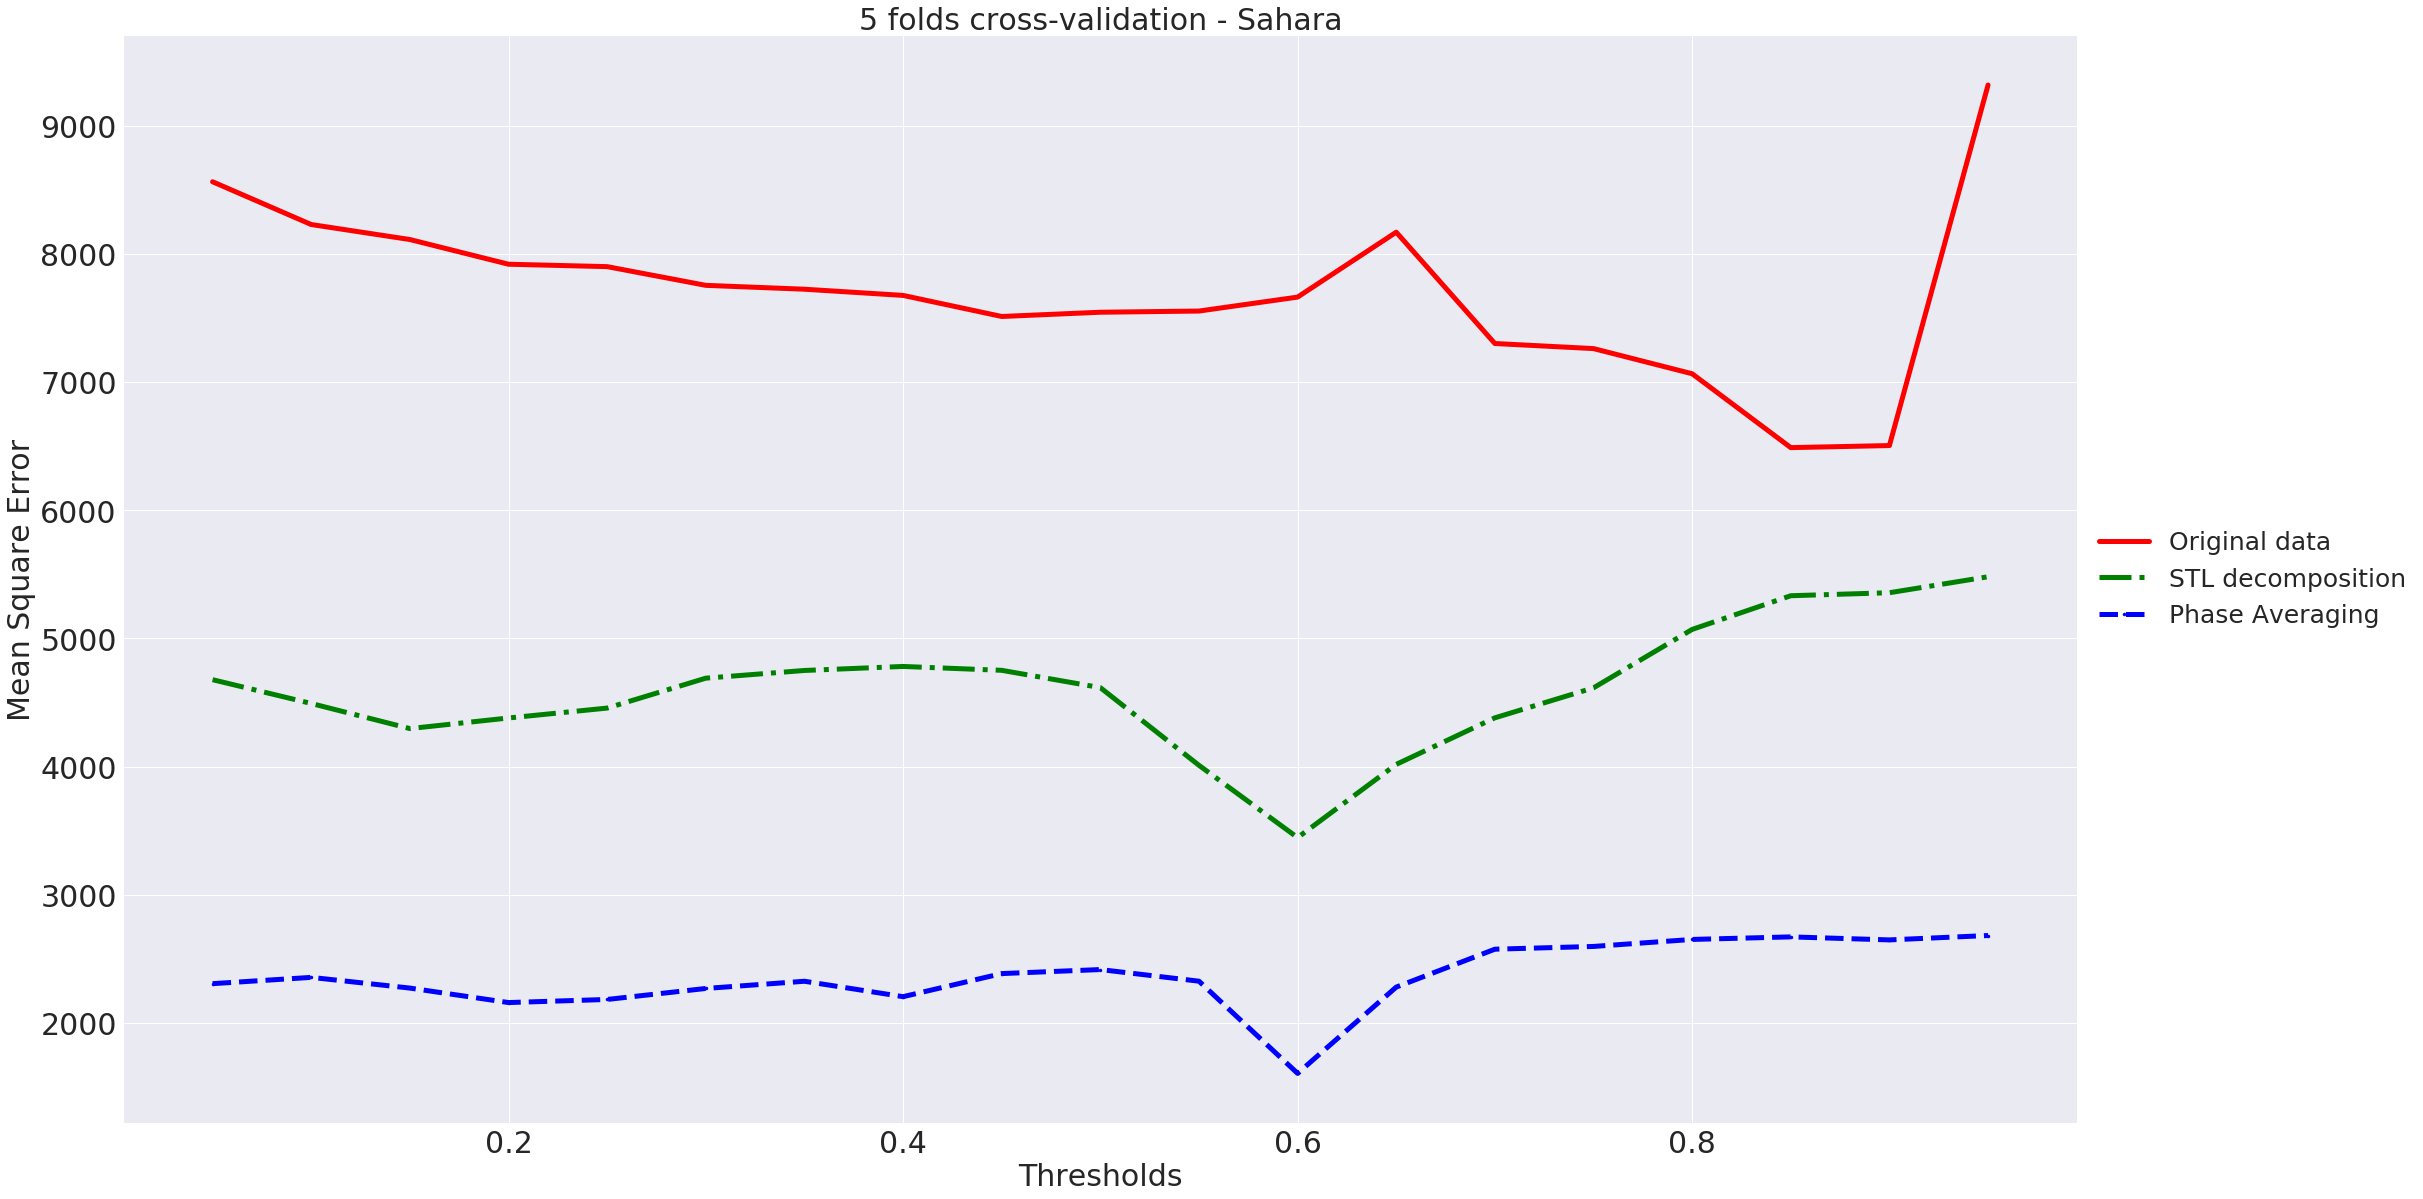

In [10]:
plt.figure(figsize=(35,20))
plt.plot(r, MSE, 'r-', r, MSE_ds, 'g-.',r,MSE_dm, 'b--.',linewidth=5)
plt.xlabel('Thresholds',fontsize=30)
plt.ylabel('Mean Square Error',fontsize=30)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.title('5 folds cross-validation - Sahara',fontsize=30)
plt.legend(['Original data','STL decomposition', 'Phase Averaging'], ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize =25)
plt.savefig("cross_validation_RF_all.png")

In [6]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)


d = [trace0,trace1, trace2]
    
layout = dict(title = 'evaluation on a rolling forecasting origin - Linear Regression',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error',
                         )
       )

fig = dict(data=d, layout=layout)
#pio.write_image(fig, 'performance_cross5.png')
py.iplot(fig, filename='styled-line')

In [11]:
np.std(MSE_dm)

50.858959668765515

In [7]:
math.sqrt(2477)

49.76946855251722

In [16]:
MSE = np.load("MSE_NN.npy")
MSE_ds = np.load("MSE_NN_ds.npy")
MSE_dm = np.load("MSE_NN_dm.npy")

In [17]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)


d = [trace0,trace1, trace2]
    
layout = dict(title = 'evaluation on a rolling forecasting origin - Linear Regression',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error',
                         )
       )

fig = dict(data=d, layout=layout)
#pio.write_image(fig, 'performance_cross5.png')
py.iplot(fig, filename='styled-line')

In [49]:
data = pr[14:22,3:7,:]
#data = pr[10:22,3:11,:]
#data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [50]:
MSEds_list = []
MSE_list = []
MSEdm_list = []
null_list =[]
for i in range(0,840,84):
    MSE, average_betweennes, average_shortest_path_length,density = cf.model(data,"LR","normal",start=i,end=i+84, data_type="normal")
    MSE_list.append(MSE)
    
    MSE_ds, average_betweennes_ds, average_shortest_path_length_ds, density_ds = cf.model(data,"LR","normal",start=i,end=i+84, data_type="STL")
    MSEds_list.append(MSE_ds)

    MSE_dm, average_betweennes_dm, average_shortest_path_length_dm,density_dm = cf.model(data,"LR","normal",start=i,end=i+84, data_type="PA")
    MSEdm_list.append(MSE_dm)
    
 #   null = cf.exponential_smoothing(data[i:i+168-1,:], 0.95)
 #   error = mean_squared_error(data[i+168-1,:], null)
 #   null_list.append(error)

In [51]:
f = np.matrix(MSE_list).mean(axis=0)
MSE = np.reshape(f,(19,1))

f1 = np.matrix(MSEds_list).mean(axis=0)
MSE_ds = np.reshape(f1,(19,1))

f2 = np.matrix(MSEdm_list).mean(axis=0)
MSE_dm = np.reshape(f2,(19,1))

#r_rev = r[::-1]#

#r2_upper = r2 + r2_list_bounds
#r2_lower = r2 - r2_list_bounds

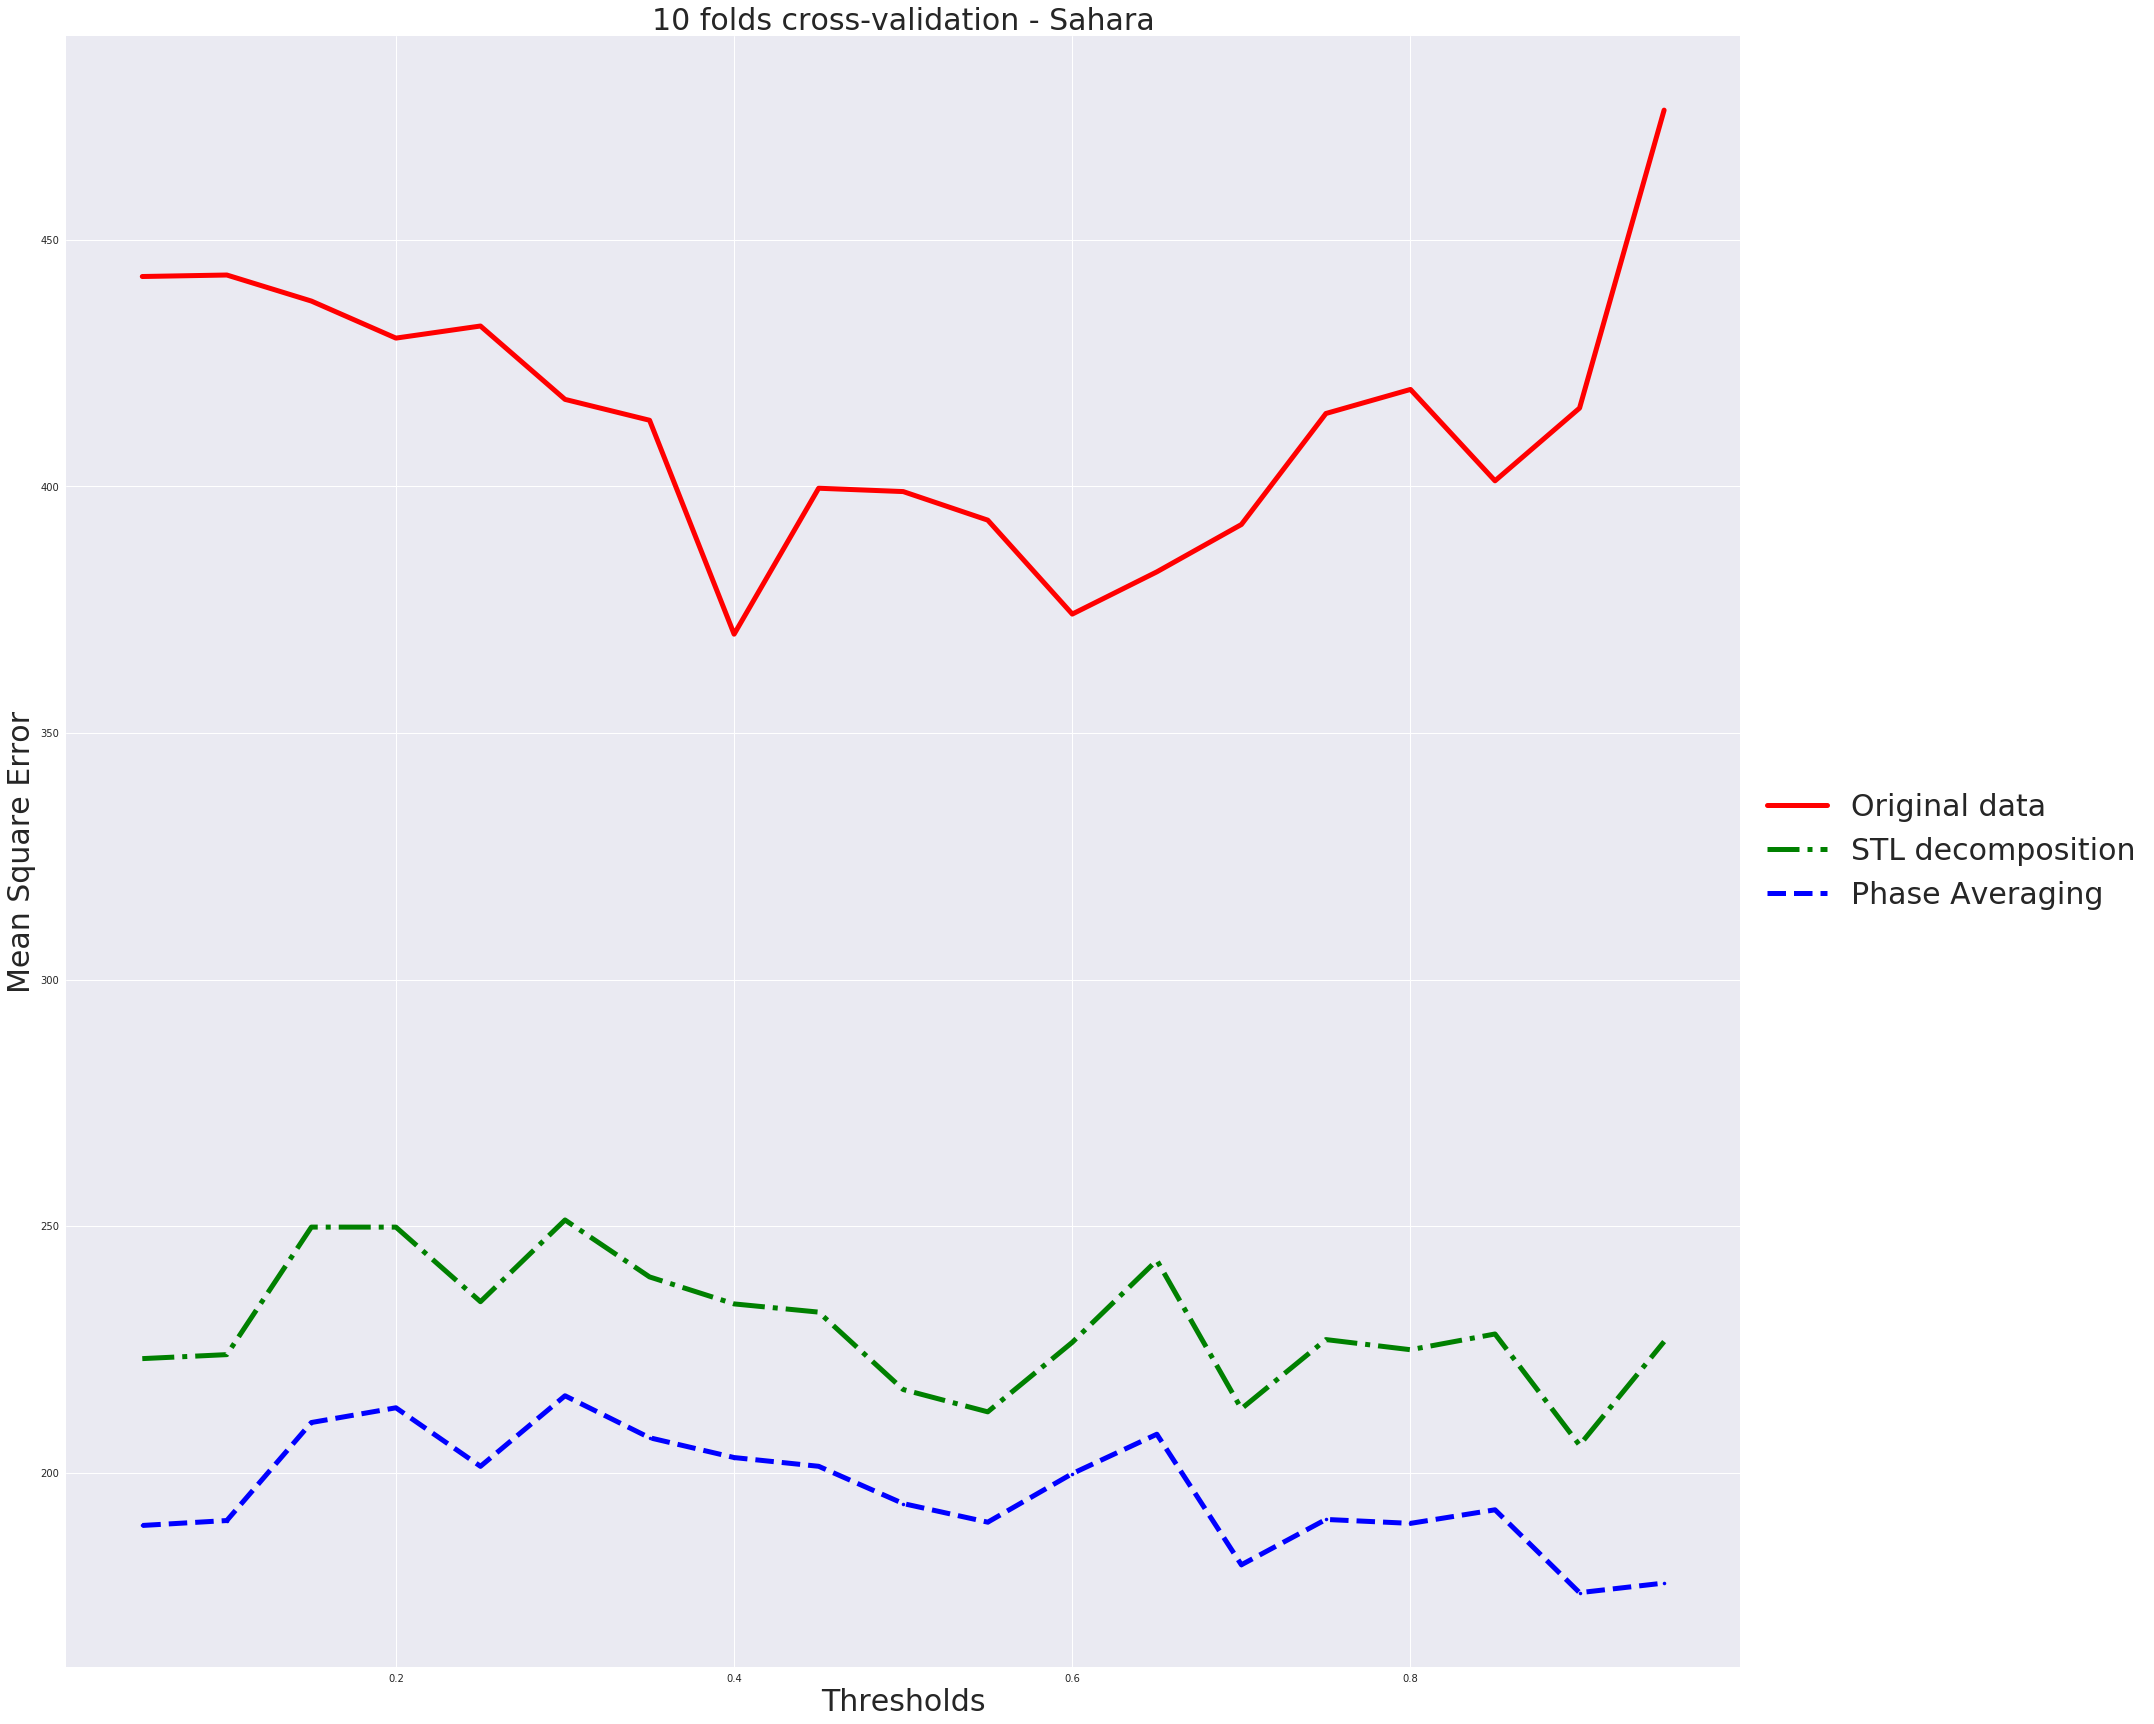

In [54]:
plt.figure(figsize=(30,30))
plt.plot(r, MSE, 'r-', r, MSE_ds, 'g-.',r,MSE_dm, 'b--.',linewidth=5)
plt.xlabel('Thresholds',fontsize=30)
plt.ylabel('Mean Square Error',fontsize=30)
plt.title('10 folds cross-validation - Sahara',fontsize=30)
plt.legend(['Original data','STL decomposition', 'Phase Averaging'], ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize =30)
plt.savefig("performance_cross10_sahara.png")

In [32]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)


d = [trace0,trace1, trace2]
    
layout = dict(title = '10-folds cross-validation',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error',
                         )
       )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'performance_cross10.png')
py.iplot(fig, filename='styled-line')

In [55]:
data = pr[14:22,3:7,:]
#data = pr[10:22,3:11,:]
#data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [56]:
MSEds_list = []
MSE_list = []
MSEdm_list = []
null_list =[]
for i in range(0,840,42):
    MSE, average_betweennes, average_shortest_path_length,density = cf.model(data,"LR","normal",start=0,end=i+42, data_type="normal")
    MSE_list.append(MSE)
    
    MSE_ds, average_betweennes_ds, average_shortest_path_length_ds, density_ds = cf.model(data,"LR","normal",start=0,end=i+42, data_type="STL")
    MSEds_list.append(MSE_ds)

    MSE_dm, average_betweennes_dm, average_shortest_path_length_dm,density_dm = cf.model(data,"LR","normal",start=0,end=i+42, data_type="PA")
    MSEdm_list.append(MSE_dm)
    
 #   null = cf.exponential_smoothing(data[i:i+168-1,:], 0.95)
 #   error = mean_squared_error(data[i+168-1,:], null)
 #   null_list.append(error)

In [57]:
f = np.matrix(MSE_list).mean(axis=0)
MSE = np.reshape(f,(19,1))

f1 = np.matrix(MSEds_list).mean(axis=0)
MSE_ds = np.reshape(f1,(19,1))

f2 = np.matrix(MSEdm_list).mean(axis=0)
MSE_dm = np.reshape(f2,(19,1))

#r_rev = r[::-1]#

#r2_upper = r2 + r2_list_bounds
#r2_lower = r2 - r2_list_bounds

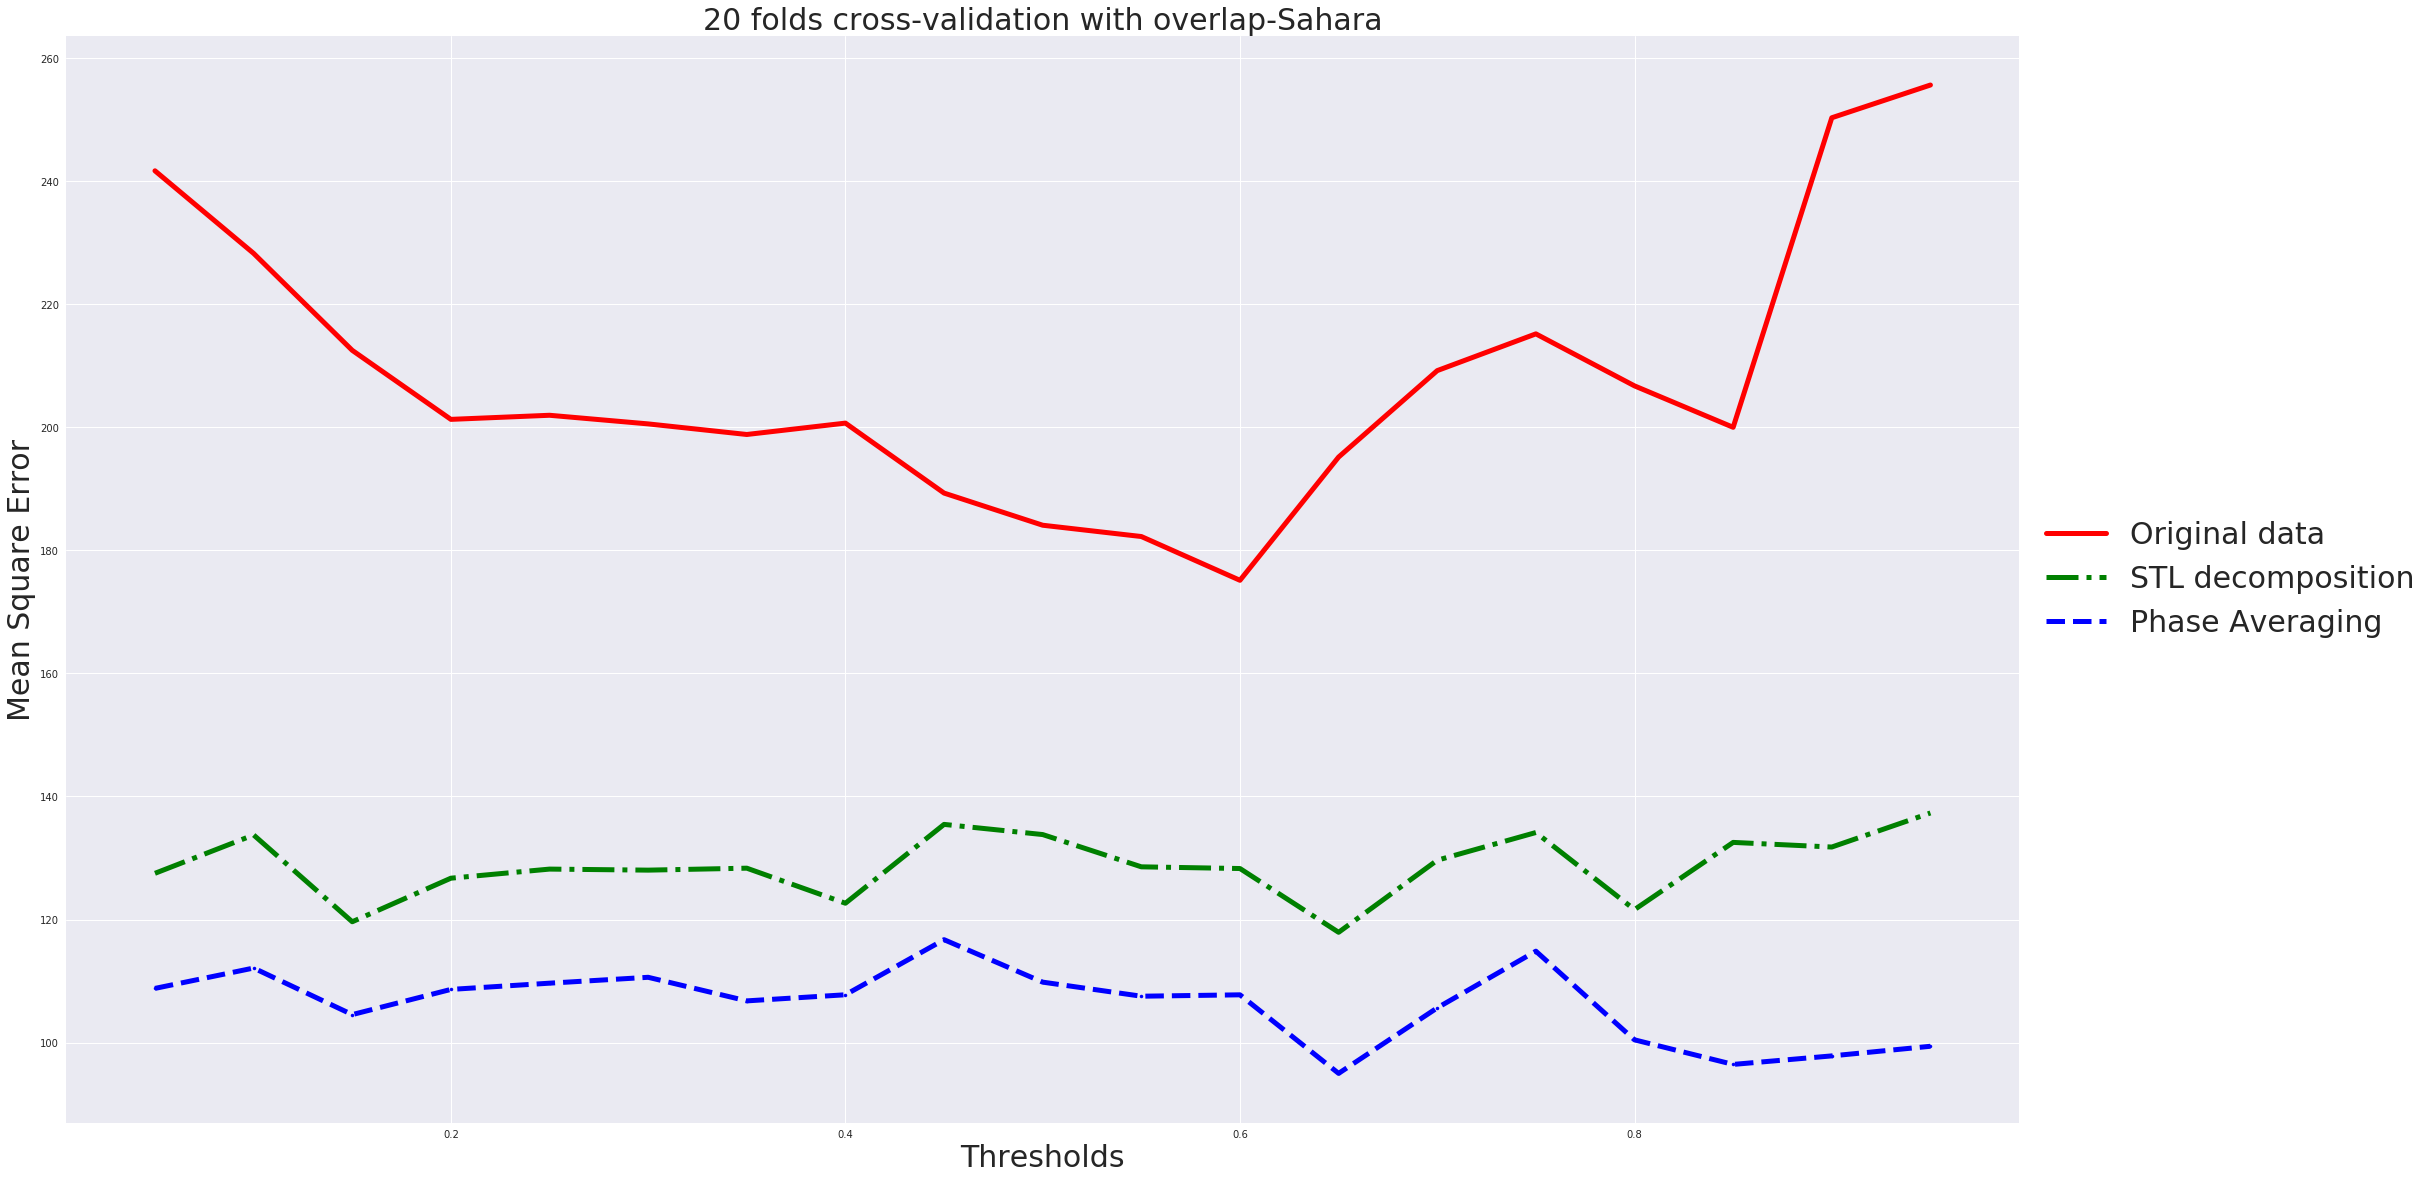

In [58]:
plt.figure(figsize=(35,20))
plt.plot(r, MSE, 'r-', r, MSE_ds, 'g-.',r,MSE_dm, 'b--.',linewidth=5)
plt.xlabel('Thresholds',fontsize=30)
plt.ylabel('Mean Square Error',fontsize=30)
plt.title('20 folds cross-validation with overlap-Sahara',fontsize=30)
plt.legend(['Original data','STL decomposition', 'Phase Averaging'], ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize =30)
plt.savefig("performance_cross_overlaps_sahara.png")

In [124]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)


d = [trace0,trace1, trace2]
    
layout = dict(title = '10-folds cross-validation',
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error',
                         )
       )

fig = dict(data=d, layout=layout)
#pio.write_image(fig, 'performance_cross5_overlap.png')
py.iplot(fig, filename='styled-line')

In [17]:
    df_pr = pd.DataFrame(list(zip(MSE, MSE_ds, MSE_dm)),
                     columns=['Original data', 'STL decomposition', 'Phase Averaging'])

In [18]:
 ax = sns.lineplot(data=wide_df)

AttributeError: module 'seaborn' has no attribute 'lineplot'

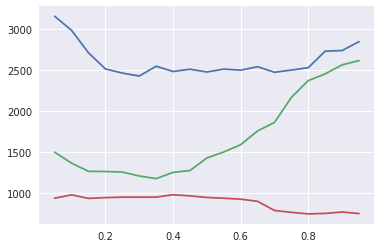

In [21]:
plt.plot(r,df_pr,'-');

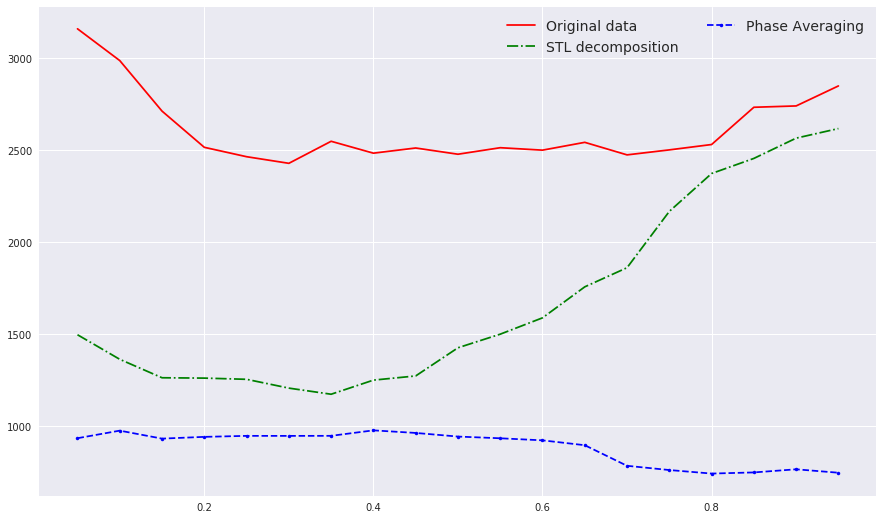

In [45]:
plt.figure(figsize=(15,9))
plt.plot(r, MSE, 'r-', r, MSE_ds, 'g-.',r,MSE_dm, 'b--.',)
plt.legend(['Original data','STL decomposition', 'Phase Averaging'], ncol=2, loc='upper right', fontsize =14)
plt.savefig("performance_cross.png")

In [13]:
fmri = sns.load_dataset("fmri")

In [14]:
fmri.head()

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970


In [53]:
s = 0
for i in range(10):
    print(MSEdm_list[i][18])

564.1450454903021
442.39247086743336
336.13308361756833
504.91276593519353
194.59610658957
113.22126650409761
182.7093410213915
110.5826403845886
139.36772322080478
231.19074048549564


In [51]:
s/10

281.9251184116445

In [38]:
MSE_dm

matrix([[360.38151861],
        [382.14536856],
        [377.06243456],
        [389.65550242],
        [376.09927673],
        [383.79025936],
        [396.11083346],
        [409.9618373 ],
        [388.39045638],
        [362.95398603],
        [341.20478027],
        [329.0085221 ],
        [329.65697814],
        [293.85078235],
        [286.44168875],
        [287.22452129],
        [281.62552114],
        [278.71174411],
        [281.92511841]])

In [19]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = np.repeat(error, 19),
    name = 'Exponential smoothing',
    line = dict(
        color = ('rgb(100, 10, 240)'),
        width = 0.5, 
        dash = 'longdash')
)

d = [trace0,trace1, trace2, trace3]
    
layout = dict(title = 'Models Performance',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error')
       )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'performance_cross.png')
py.iplot(fig, filename='styled-line')


In [16]:

trace0 = go.Scatter(
    x = r ,
    y = MSE,
    name = 'normal data',
    mode = 'lines',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,dash = 'dot'),
   # fillcolor='rgba(68, 68, 68, 0.3)',
    #fill='tonexty'
)

trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL deseasonal data',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 2,
        dash = 'dot')
)   
trace2 = go.Scatter(
    x = r,
    y = MSE_dm,
    name = 'PA deseasonal data',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)



d = [trace0, trace1]
    
layout = dict(title = 'Comparison of normal and deseasonal data',
              width=1000,
              height=800,
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'R-squared',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000')
            
              )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'performance_cross_12.png')
py.iplot(fig, filename='styled-line')

PlotlyRequestError: Hi there, you've reached the threshold of 100 combined image exports and chart saves per 24h period. If you need to raise your daily limit, please consider upgrading to a paid plan.

# Matrix Distribution

In [4]:
end = 1
start= 0

In [5]:
data_deseasonal = data
data_seasonal = np.zeros(data.shape[1]) 
m = nb.weighted_matrix(data_deseasonal[start:-end-1,:])

In [6]:
h = cf.flatten2d(np.absolute(m))
layout = dict(title = 'Distribution of edge weights - original data',
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.1,))
d = [go.Histogram(x=h)]
fig = go.Figure(data=d, layout=layout)
pio.write_image(fig, 'distribution_normal.png')
py.iplot(fig, filename='basic histogram')

In [7]:
#data = pr[10:22,3:11,:]
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [8]:
data_deseasonal, data_seasonal = cf.deseasonal_monthly_anomaly(data)
data_seasonal = data_seasonal[0,:]
m = nb.weighted_matrix(data_deseasonal[start:-end-1,:])

In [10]:
h = cf.flatten2d(np.absolute(m))
layout = dict(title = 'Distribution of edge weights - original data',
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.1,))
d = [go.Histogram(x=h)]
fig = go.Figure(data=d, layout=layout)
pio.write_image(fig, 'distribution_pa.png')
py.iplot(fig, filename='basic histogram')

In [9]:
h = cf.flatten2d(np.absolute(m))
layout = dict(title = 'Distribution of edge weights - phase averaging deseasonalized data'),
                titlefont = dict(size =24))
d = [go.Histogram(x=h)]
fig = go.Figure(data=d, layout=layout)
pio.write_image(fig, 'distribution_pa.png')
py.iplot(d, filename='basic histogram')

IndentationError: unexpected indent (<ipython-input-9-fd1289b5717b>, line 3)

In [128]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [17]:
data_deseasonal, data_seasonal = cf.deseasonal_STL(data)
data_seasonal = data_seasonal[-end,:]
m = nb.weighted_matrix(data_deseasonal[start:-end-1,:])

In [12]:
h = cf.flatten2d(np.absolute(m))
layout = dict(title = 'Distribution of edge weights - STL deseasonalized data',)
d = [go.Histogram(x=h)]
fig = go.Figure(data=d, layout=layout)
pio.write_image(fig, 'distribution_STL.png')
py.iplot(d, filename='basic histogram')

# Linear Regression

In [12]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
data = cf.refine_data(data)
MSE,SP,density = cf.model(data,model_type ="LR",feature = "normal")

In [13]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
data = cf.refine_data(data)
MSE_ds,SP_ds,density_ds = cf.model(data,model_type ="LR",feature = "normal",data_type = "STL")

In [14]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
data = cf.refine_data(data)
MSE_dm,SP_dm, density_dm = cf.model(data,model_type ="LR",feature = "normal",data_type = "PA")

In [7]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
data = cf.refine_data(data)
MSE_cf,SP_cf, density_cf = cf.model(data,model_type ="LR",feature = "normal",data_type = "CF")

In [3]:
data = pr
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
data = cf.refine_data(data)

In [11]:
#MSE,SP,density = cf.model(data,"LR","normal")

In [24]:
MSE = np.load("MSE_NN_overall.npy")
MSE_ds = np.load("MSE_NN_ds_overall.npy")
MSE_dm = np.load("MSE_NN_dm_overall.npy")

In [21]:
data = pr
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
data = cf.refine_data(data)

In [25]:
null = cf.exponential_smoothing(data, 0.95)
error = mean_squared_error(data[-1,:], null)

In [26]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = np.repeat(error, 19),
    name = 'Exponential smoothing',
    line = dict(
        color = ('rgb(255,69,0)'),
        width = 0.5, 
        dash = 'longdash')
)

d = [trace0,trace1, trace2, trace3]
    
layout = dict(title = 'Neural Network Performance - Africa',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error')
       )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'performance_NN_all.png')
py.iplot(fig, filename='styled-line')

In [18]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dsm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = np.repeat(error, 19),
    name = 'Exponential smoothing',
    line = dict(
        color = ('rgb(255,69,0)'),
        width = 0.5, 
        dash = 'longdash')
)

d = [trace0,trace1, trace2, trace3]
    
layout = dict(title = 'Random Forest Performance',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error')
       )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'performance_RF_all.png')
py.iplot(fig, filename='styled-line')

In [15]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = np.repeat(error, 19),
    name = 'Exponential smoothing',
    line = dict(
        color = ('rgb(255,69,0)'),
        width = 0.5, 
        dash = 'longdash')
)

#trace4 = go.Scatter(
#    x = r,
#    y = MSE_cf,
#    name = 'Curve Fitting',
#    line = dict(
#        color = ('rgb(150,69,0)'),
#        width = 0.5, 
#        dash = 'longdash')
#)

d = [trace0,trace1, trace2, trace3]
    
layout = dict(title = 'Random Forest Performance',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error')
       )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'performance_cf.png')
py.iplot(fig, filename='styled-line')

In [9]:
data_deseasonal, data_seasonal = cf.deseasonal_monthly_anomaly(data)
data_seasonal = data_seasonal[0,:]

In [40]:
data_deseasonal = data
data_seasonal = np.zeros(data.shape[1])

In [41]:
limit = 0.9
m = nb.weighted_matrix(data_deseasonal)
G, c = nb.graph_builder_limit(m, limit)
#adjacency_matrix = np.zeros(m.shape)
#adjacency_matrix[m >= limit] = 1

In [42]:
X = cf.feature_extractor(G) 

In [43]:
X

[[4,
  0.19397417503586803,
  4,
  0.0,
  0.024402117300369314,
  0.11295289212491595,
  1.0],
 [9,
  0.24981522542498152,
  5,
  0.03517368810051736,
  0.047315756937395446,
  0.29640779883588075,
  0.6111111111111112],
 [12,
  0.2794543199669285,
  5,
  0.09911013444550028,
  0.06328759158977929,
  0.3533936373930193,
  0.45454545454545453],
 [1,
  0.08770108977685522,
  1,
  0.0,
  0.021346848129956325,
  6.060097318290577e-07,
  0],
 [0, 0.0, 0, 0.0, 0.005128205128205129, 1.9666467709045298e-17, 0],
 [0, 0.0, 0, 0.0, 0.005128205128205129, 1.9666467709045298e-17, 0],
 [5,
  0.20609756097560977,
  4,
  0.0009229490022172948,
  0.029045161622579724,
  0.1530497073854725,
  0.9],
 [11,
  0.26171118854045683,
  5,
  0.05693318199415763,
  0.05688057538605629,
  0.3550960142765077,
  0.509090909090909],
 [4,
  0.21983739837398375,
  3,
  0.002857142857142857,
  0.024496400281269162,
  0.12543585009050834,
  0.6666666666666666],
 [2,
  0.10115217716594344,
  1,
  0.03048780487804878,
  0.

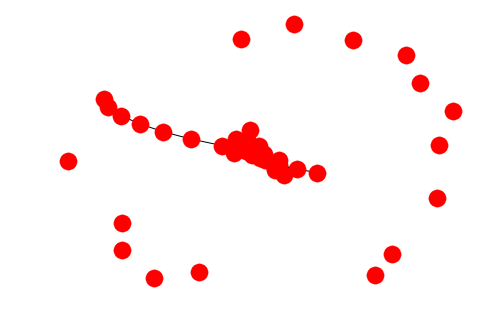

In [44]:
nx.draw(G)

# Density

In [ ]:
density = np.array(density)
density_ds = np.array(density_ds)
density_dm = np.array(density_dm)

In [ ]:
trace0 = go.Scatter(
    x = r,
    y = density,
    name = 'Edge density - origial data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2)
)
trace1 = go.Scatter(
    x = r,
    y = density_ds,
    name = 'Edge density - STL deseasonalized dat',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
) 
trace2 = go.Scatter(
    x = r,
    y = density_dm,
    name = 'Edge density - phase averaging deseasonalized data',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)
d = [trace0, trace1, trace2]
    

layout = dict(title = 'Comparison of Edge Density',
              width = 1200,
              height = 600,
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'Edge Density',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000')
              )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'edge.png')
py.iplot(fig, filename='line')

# Fisher Test

In [4]:
def fisher_test(data):
    r = np.arange(0.1,1,0.05) 
    p_limit = []
    z_limit = []
    for i in range(len(r)):
        
        n = data.shape[1]
        m = nb.weighted_matrix(data)
        m = np.absolute(m)
        # G, c = nb.graph_builder_limit(m, r[i])
    
        np.fill_diagonal(m, 0)
        Z = abs(np.arctanh(m))
        N = data.shape[0]
        SE = 1/math.sqrt(N-3)
        Z_real = np.arctanh(r[i])
        Z = (Z-Z_real)/SE
        p = st.norm.cdf(Z)
    
        adjacency_matrix = np.zeros(m.shape)
        adjacency_matrix[m > r[i]] = 1
        
        if np.count_nonzero(np.where(m > r[i])) > 0:
            p_limit.append(p[adjacency_matrix.astype(int) == 1].min())
            z_limit.append(Z[adjacency_matrix.astype(int) == 1].min())
        else:
            p_limit.append(np.NAN)
            z_limit.append(np.NAN)
            
    return(p_limit, z_limit)

In [5]:
data = pr[14:22,3:7,:]
#data = pr[10:22,3:11,:]
#data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [6]:
data_deseasonal = data[600:,:]
data_seasonal = np.zeros(data.shape[1]) 

p_limit, z_limit = fisher_test(data_deseasonal)

In [7]:
data = pr[14:22,3:7,:]
#data = pr[10:22,3:11,:]
#data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [8]:
data_deseasonal, data_seasonal = cf.deseasonal_monthly_anomaly(data[600:,:])
data_seasonal = data_seasonal[0,:]

p_limit_dm, z_limit_dm = fisher_test(data_deseasonal)

In [9]:
data = pr[14:22,3:7,:]
#data = pr[10:22,3:11,:]
#data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [10]:
data_deseasonal, data_seasonal = cf.deseasonal_monthly_anomaly(data[600:,:])
data_seasonal = data_seasonal[0,:]

p_limit_ds, z_limit_ds = fisher_test(data_deseasonal)

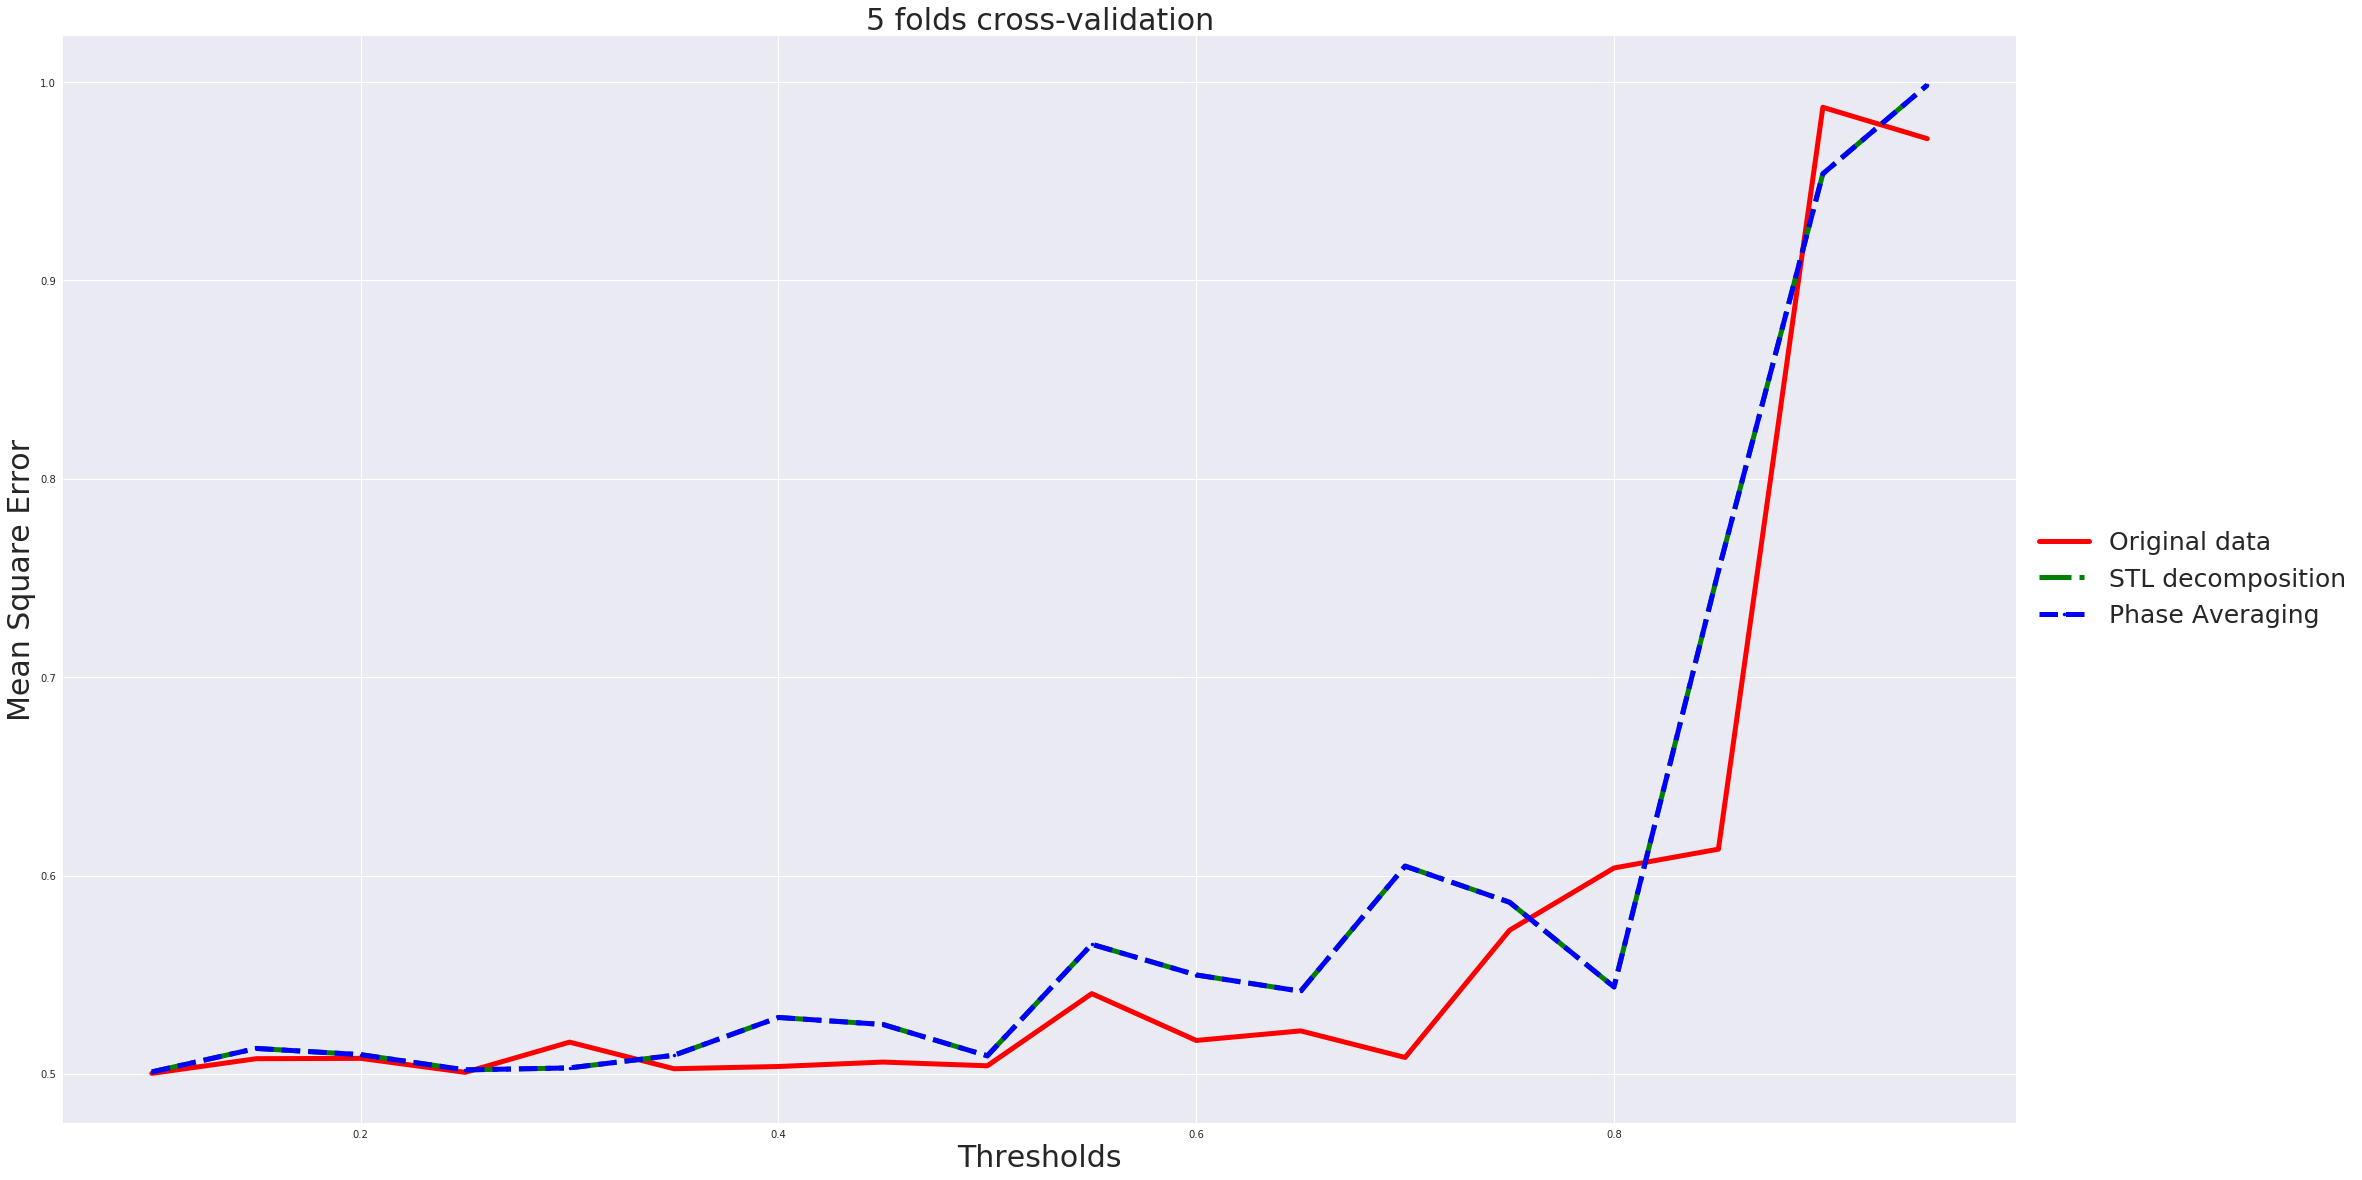

In [11]:
plt.figure(figsize=(35,20))
r = np.arange(0.1,1,0.05)
plt.plot(r, p_limit, 'r-', r, p_limit_ds, 'g-.',r,p_limit_dm, 'b--.',linewidth=5)
plt.xlabel('Thresholds',fontsize=30)
plt.ylabel('Mean Square Error',fontsize=30)
plt.title('5 folds cross-validation',fontsize=30)
plt.legend(['Original data','STL decomposition', 'Phase Averaging'], ncol=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize =25)
plt.savefig("fisher var sahara.png")

In [13]:
trace0 = go.Scatter(
    x = r,
    y = p_limit,
    name = 'Confidence Level - origial data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2)
)
trace1 = go.Scatter(
    x = r,
    y = p_limit_ds,
    name = 'Confidence Level - STL deseasonalized dat',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
) 
trace2 = go.Scatter(
    x = r,
    y = p_limit_dm,
    name = 'Confidence Level - phase averaging deseasonalized data',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)
d = [trace0, trace1, trace2]
    

layout = dict(title = 'Comparison of confidence levels - Sahara',
              width = 970,
              height = 600,
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'Confidence Level',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000')
              )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'fisher var sahara 1.png')
py.iplot(fig, filename='line')

In [27]:
SP = np.load("SP_LR_overall.npy")
SP_ds = np.load("SP_LR_ds_overall.npy")
SP_dm = np.load("SP_LR_dm_overall.npy")

In [28]:
trace0 = go.Scatter(
    x = r,
    y = SP,
    name = 'Average Shortest Path - origial data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2)
)
trace1 = go.Scatter(
    x = r,
    y = SP_ds,
    name = 'Average Shortest Path - STL deseasonalized data',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
) 
trace2 = go.Scatter(
    x = r,
    y = SP_dm,
    name = 'Average Shortest Path- phase averaging deseasonalized data',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)
 
d = [trace0, trace1, trace2]
    
layout = dict(title = 'Comparison of Average Shortest Path',
              width = 980,
              xaxis = dict(title = 'Thresholds'),
              yaxis = dict(title = 'Average Shortest Path'),
 #             shapes = [
 #       {
 #           'type': 'line',
 #           'x0': 0.35,
 #           'y0': 0,
 #           'x1': 0.35,
 #           'y1': 3.5,
  #          'line': {
   #             'color': 'rgb(0, 0, 0)',
   #             'width': 0.5,
   #         },
    #    }]
              )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'path_all.png')
py.iplot(fig, filename='styled-line')

In [9]:
trace0 = go.Scatter(
    x = r,
    y = average_betweennes,
    name = 'eigenvector centrality - origial data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2)
)
trace1 = go.Scatter(
    x = r,
    y = average_betweennes_ds,
    name = 'eigenvector centrality- STL deseasonalized dat',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
) 
trace2 = go.Scatter(
    x = r,
    y = average_betweennes_dsm,
    name = 'eigenvector centrality- phase averaging deseasonalized dat',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)
 
d = [trace0, trace1, trace2]
    
layout = dict(title = 'Comparison of Average eigenvector centrality',
              width = 980,
              xaxis = dict(title = 'Thresholds'),
              yaxis = dict(title = 'Eigenvector Centrality'),
 #             shapes = [
 #       {
 #           'type': 'line',
 #           'x0': 0.35,
 #           'y0': 0,
 #           'x1': 0.35,
 #           'y1': 3.5,
  #          'line': {
   #             'color': 'rgb(0, 0, 0)',
   #             'width': 0.5,
   #         },
    #    }]
              )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'eigenvector.png')
py.iplot(fig, filename='styled-line')

# Neural Network

In [164]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [165]:
MSE, average_betweennes, average_shortest_path_length, density = cf.model(data,"NN","normal")

data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
MSE_ds, average_betweennes_ds, average_shortest_path_length_ds, density_ds = cf.model(data,"NN","normal",data_type = "STL")

data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
MSE_dsm, average_betweennes_dsm, average_shortest_path_length_dsm, density_dm = cf.model(data,"NN","normal",data_type = "PA")

null = cf.exponential_smoothing(data, 0.95)
error = mean_squared_error(data[-1,:], null)

In [166]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dsm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = np.repeat(error, 19),
    name = 'Exponential smoothing',
    line = dict(
        color = ('rgb(100, 10, 240)'),
        width = 0.5, 
        dash = 'longdash')
)

d = [trace0,trace1, trace2, trace3]
    
layout = dict(title = 'Neural Network Performance',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error',range=[0,800])
       )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'performance_NN.png')
py.iplot(fig, filename='styled-line')

# Random Forest

In [102]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [104]:
MSE, average_betweennes, average_shortest_path_length, density = cf.model(data,"RF","normal")

data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
MSE_ds, average_betweennes_ds, average_shortest_path_length_ds, density_ds = cf.model(data,"RF","normal",data_type = "STL")

data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)
MSE_dsm, average_betweennes_dsm, average_shortest_path_length_dsm, density_dm = cf.model(data,"RF","normal",data_type = "PA")

null = cf.exponential_smoothing(data, 0.95)
error = mean_squared_error(data[-1,:], null)

In [105]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dsm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = np.repeat(error, 19),
    name = 'Exponential smoothing',
    line = dict(
        color = ('rgb(100, 10, 240)'),
        width = 0.5, 
        dash = 'longdash')
)

d = [trace0,trace1, trace2, trace3]
    
layout = dict(title = 'Random Forest Performance',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error',range=[0,800])
       )

fig = dict(data=d, layout=layout)
#pio.write_image(fig, 'performance_RF.png')
py.iplot(fig, filename='styled-line')

# Feature Importance

In [176]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [177]:
r = np.arange(0.1,1,0.05)
df = cf.feature_importance(data)

In [178]:
trace0 = go.Scatter(
    x = r,
    y = df['degree'],
    name = 'degree',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
    dash = 'solid')
)
 
trace2 = go.Scatter(
    x = r,
    y = df['closseness'],
    name = 'closseness',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = df['kcore'],
    name = 'kcore',
    line = dict(
        color = ('rgb(202, 125, 68)'),
        width = 4,
        dash = 'dot')
)
trace4 = go.Scatter(
    x = r,
    y = df['betweeness'],
    name = 'betweeness',
    line = dict(
        color = ('rgb(105, 184, 68)'),
        width = 4,
        dash = 'dashdot')
)
trace5 = go.Scatter(
    x = r,
    y = df['pagerank'],
    name = 'pagerank',
    line = dict(
        color = ('rgb(3, 1, 5)'),
        width = 4,
        dash = 'longdashdot')
)
trace6 = go.Scatter(
    x = r,
    y = df['eigenvector'],
    name = 'eigenvector',
    line = dict(
        color = ('rgb(239, 38, 205)'),
        width = 4,
        dash = 'longdash')
)
trace7 = go.Scatter(
    x = r,
    y = df['clustering'],
    name = 'clustering',
    line = dict(
        color = ('rgb(248, 215, 34)'),
        width = 4,
        dash = 'dash')
)
d = [trace0, trace2, trace3, trace4, trace5, trace6, trace7]

layout = dict(title = 'Features importance ranking - Original data',
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'Importance',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'Feature Importance.png')
py.iplot(fig, filename='styled-line')

In [179]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [180]:
data_deseasonal, data_seasonal= cf.deseasonal_monthly_anomaly(data)
df = cf.feature_importance(data_deseasonal)

trace0 = go.Scatter(
    x = r,
    y = df['degree'],
    name = 'degree',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
    dash = 'solid')
)
 
trace2 = go.Scatter(
    x = r,
    y = df['closseness'],
    name = 'closseness',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = df['kcore'],
    name = 'kcore',
    line = dict(
        color = ('rgb(202, 125, 68)'),
        width = 4,
        dash = 'dot')
)
trace4 = go.Scatter(
    x = r,
    y = df['betweeness'],
    name = 'betweeness',
    line = dict(
        color = ('rgb(105, 184, 68)'),
        width = 4,
        dash = 'dashdot')
)
trace5 = go.Scatter(
    x = r,
    y = df['pagerank'],
    name = 'pagerank',
    line = dict(
        color = ('rgb(3, 1, 5)'),
        width = 4,
        dash = 'longdashdot')
)
trace6 = go.Scatter(
    x = r,
    y = df['eigenvector'],
    name = 'eigenvector',
    line = dict(
        color = ('rgb(239, 38, 205)'),
        width = 4,
        dash = 'longdash')
)
trace7 = go.Scatter(
    x = r,
    y = df['clustering'],
    name = 'clustering',
    line = dict(
        color = ('rgb(248, 215, 34)'),
        width = 4,
        dash = 'dash')
)
d = [trace0, trace2, trace3, trace4, trace5, trace6, trace7]

layout = dict(title = 'Features importance ranking - phase averaging deseasonalized data',
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'Importance',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'Feature Importance PA.png')
py.iplot(fig, filename='styled-line')

In [182]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [183]:
data_deseasonal, data_seasonal= cf.deseasonal_STL(data)
df = cf.feature_importance(data_deseasonal)

trace0 = go.Scatter(
    x = r,
    y = df['degree'],
    name = 'degree',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
    dash = 'solid')
)
 
trace2 = go.Scatter(
    x = r,
    y = df['closseness'],
    name = 'closseness',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = df['kcore'],
    name = 'kcore',
    line = dict(
        color = ('rgb(202, 125, 68)'),
        width = 4,
        dash = 'dot')
)
trace4 = go.Scatter(
    x = r,
    y = df['betweeness'],
    name = 'betweeness',
    line = dict(
        color = ('rgb(105, 184, 68)'),
        width = 4,
        dash = 'dashdot')
)
trace5 = go.Scatter(
    x = r,
    y = df['pagerank'],
    name = 'pagerank',
    line = dict(
        color = ('rgb(3, 1, 5)'),
        width = 4,
        dash = 'longdashdot')
)
trace6 = go.Scatter(
    x = r,
    y = df['eigenvector'],
    name = 'eigenvector',
    line = dict(
        color = ('rgb(239, 38, 205)'),
        width = 4,
        dash = 'longdash')
)
trace7 = go.Scatter(
    x = r,
    y = df['clustering'],
    name = 'clustering',
    line = dict(
        color = ('rgb(248, 215, 34)'),
        width = 4,
        dash = 'dash')
)
d = [trace0, trace2, trace3, trace4, trace5, trace6, trace7]

layout = dict(title = 'Features importance ranking - STL deseasonalized data',
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'Importance',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'Feature Importance STL.png')
py.iplot(fig, filename='styled-line')

In [41]:
data = pr[16:23,10:16,:]
data = cf.unflatten(data)
data = np.swapaxes(data,0,1)

In [42]:
data_deseasonal, data_seasonal= cf.deseasonal_monthly_anomaly(data)
df = cf.feature_importance(data_deseasonal)

trace0 = go.Scatter(
    x = r,
    y = df['degree'],
    name = 'degree',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,
    dash = 'solid')
)
 
trace2 = go.Scatter(
    x = r,
    y = df['closseness'],
    name = 'closseness',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = df['kcore'],
    name = 'kcore',
    line = dict(
        color = ('rgb(202, 125, 68)'),
        width = 4,
        dash = 'dot')
)
trace4 = go.Scatter(
    x = r,
    y = df['betweeness'],
    name = 'betweeness',
    line = dict(
        color = ('rgb(105, 184, 68)'),
        width = 4,
        dash = 'dashdot')
)
trace5 = go.Scatter(
    x = r,
    y = df['pagerank'],
    name = 'pagerank',
    line = dict(
        color = ('rgb(3, 1, 5)'),
        width = 4,
        dash = 'longdashdot')
)
trace6 = go.Scatter(
    x = r,
    y = df['eigenvector'],
    name = 'eigenvector',
    line = dict(
        color = ('rgb(239, 38, 205)'),
        width = 4,
        dash = 'longdash')
)
trace7 = go.Scatter(
    x = r,
    y = df['clustering'],
    name = 'clustering',
    line = dict(
        color = ('rgb(248, 215, 34)'),
        width = 4,
        dash = 'dash')
)
d = [trace0, trace2, trace3, trace4, trace5, trace6, trace7]

layout = dict(title = 'Features Importance using Anomaly deseasonal Data',
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'Importance',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              )

fig = dict(data=d, layout=layout)
py.iplot(fig, filename='styled-line')

In [8]:
trace = go.Scatter(
    x = r,
    y = MSE
)

data = [trace]
layout = {}
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename='line-mode')

In [ ]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'MSE of normal data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'MSE of STL deseasonal data',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dsm,
    name = 'MSE of monthly deseasonal data',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

d = [trace0, trace1, trace2]
    
layout = dict(title = 'Comparison of normal and deseasonal data',
              height=800,
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'R-squared',
              showticklabels=True,

              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
       )

fig = dict(data=d, layout=layout)
py.iplot(fig, filename='styled-line')

In [ ]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'MSE of normal data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'MSE of STL deseasonal data',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dsm,
    name = 'MSE of monthly deseasonal data',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

d = [trace0, trace1, trace2]
    
layout = dict(title = 'Comparison of normal and deseasonal data',
              height=800,
              xaxis = dict(title = 'Thresholds',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000'),
              yaxis = dict(title = 'R-squared',
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
             # dtick=0.1,
              ticklen=8,
              tickwidth=4,
              tickcolor='#000')
            
              )

fig = dict(data=d, layout=layout)
py.iplot(fig, filename='styled-line')

In [ ]:
trace0 = go.Scatter(
    x = r,
    y = MSE,
    name = 'Original data',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 2,)
)
trace1 = go.Scatter(
    x = r,
    y = MSE_ds,
    name = 'STL decomposition',
    line = dict(
        color = ('rgb(22, 167, 40)'),
        width = 2,
        dash = 'dot')
)    

trace2 = go.Scatter(
    x = r,
    y = MSE_dsm,
    name = 'Phase Averaging',
    line = dict(
        color = ('rgb(33, 164, 242)'),
        width = 4,
        dash = 'dash')
)

trace3 = go.Scatter(
    x = r,
    y = np.repeat(error, 19),
    name = 'Exponential smoothing',
    line = dict(
        color = ('rgb(100, 10, 240)'),
        width = 0.5, 
        dash = 'longdash')
)

d = [trace0,trace1, trace2, trace3]
    
layout = dict(title = 'Models Performance',
              height=800,
              width = 800,
              xaxis = dict(title = 'Thresholds',              
              showticklabels=True,
              tickmode='linear',
              ticks='outside',
              tick0=0,
              dtick=0.05,),
              yaxis = dict(title = 'Mean Square Error',range=[0,800])
       )

fig = dict(data=d, layout=layout)
pio.write_image(fig, 'performance.png')
py.iplot(fig, filename='styled-line')
